In [1]:
from matplotlib import pyplot as plt
import matplotlib
plt.style.use('ggplot')
%matplotlib inline

import logging
logging.basicConfig(level=logging.WARNING)

import pandas as pd
pd.set_option('precision', 4)

from triage.component.audition.distance_from_best import DistanceFromBestTable, BestDistancePlotter

In [2]:
import json
from triage import create_engine

with open('config/db_default_profile.json') as f:
    DB_CONFIG = json.load(f)

conn = create_engine(
    f"postgresql://{DB_CONFIG['user']}:{DB_CONFIG['pass']}@{DB_CONFIG['host']}/{DB_CONFIG['db']}"
)


In [3]:
from triage.component.audition.pre_audition import PreAudition
pre_aud = PreAudition(conn)

# select model groups by experiment hash id
model_groups = pre_aud.get_model_groups_from_experiment('357e3a5bc7d3d7cfc2c13db8ea428413')
model_groups = model_groups + pre_aud.get_model_groups_from_experiment('a9bf255077d0f97c160e06761c01c637')

len(model_groups)

595

In [4]:
sel = """
SELECT DISTINCT train_end_time
FROM model_metadata.models
WHERE model_group_id IN ({})
;
""".format(', '.join(map(str, model_groups)))

end_times = pre_aud.get_train_end_times(query=sel)
end_times

[Timestamp('2011-06-01 00:00:00'),
 Timestamp('2011-09-01 00:00:00'),
 Timestamp('2011-12-01 00:00:00'),
 Timestamp('2012-03-01 00:00:00'),
 Timestamp('2012-06-01 00:00:00'),
 Timestamp('2012-09-01 00:00:00'),
 Timestamp('2012-12-01 00:00:00'),
 Timestamp('2013-03-01 00:00:00'),
 Timestamp('2013-06-01 00:00:00'),
 Timestamp('2013-09-01 00:00:00'),
 Timestamp('2013-12-01 00:00:00'),
 Timestamp('2014-03-01 00:00:00'),
 Timestamp('2014-06-01 00:00:00'),
 Timestamp('2014-09-01 00:00:00'),
 Timestamp('2014-12-01 00:00:00'),
 Timestamp('2015-03-01 00:00:00'),
 Timestamp('2015-06-01 00:00:00'),
 Timestamp('2015-09-01 00:00:00'),
 Timestamp('2015-12-01 00:00:00'),
 Timestamp('2016-03-01 00:00:00'),
 Timestamp('2016-06-01 00:00:00')]

In [5]:
len(end_times)

21

In [6]:
from triage.component.audition import Auditioner

In [7]:
metric = 'precision@'
parameter = '500_abs'

In [8]:
aud = Auditioner(
    db_engine = conn,
    model_group_ids = model_groups,
    train_end_times = end_times,
    initial_metric_filters = [{'metric': metric, 'parameter': parameter, 'max_from_best': 1.0, 'threshold_value': 0.0}],
    models_table = 'models',
    distance_table = 'triage4_dist'
)

In [9]:
%matplotlib inline

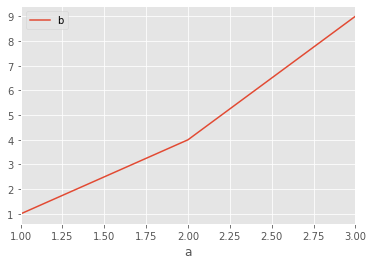

In [10]:
df = pd.DataFrame({'a': [1,2,3], 'b': [1,4,9]})

df.plot('a', 'b')

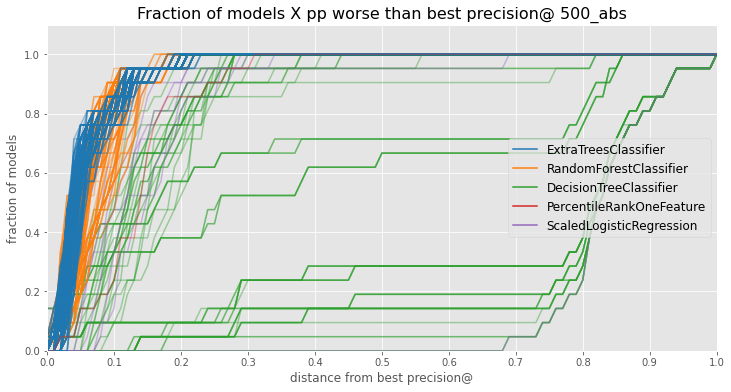

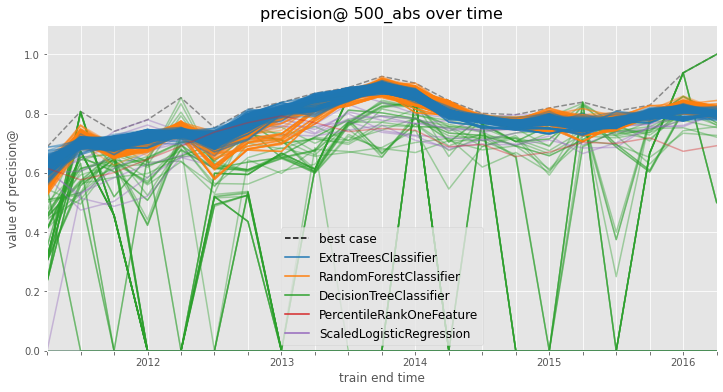

In [11]:
aud.plot_model_groups()

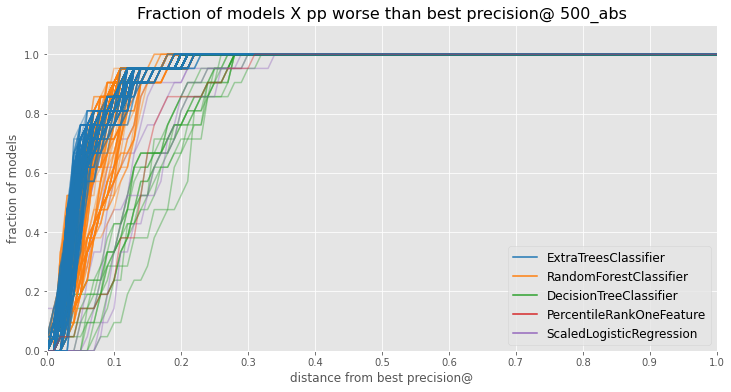

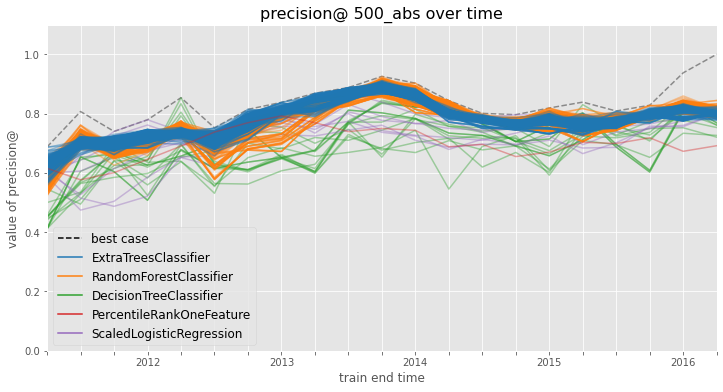

551

In [12]:
aud.update_metric_filters([{
    'metric': metric, 
    'parameter': parameter, 
    'max_from_best': 0.1, 
    'threshold_value': 0.4
}])
len(aud.thresholded_model_group_ids)

Could perhaps go with this set, but might want to just eliminate the decision trees entirely given how noisy they are in the inspection context -- presumably some have very low support, yielding the extreme values on precision...


Let's try explicitly excluding the shallow decision trees (and those with high min_samples_split):

In [42]:
sel = """
SELECT DISTINCT model_group_id
FROM model_metadata.model_groups
WHERE model_type ILIKE '%%DecisionTree%%'
    AND (
        (hyperparameters->'max_depth')::INT < 20
        OR
        (hyperparameters->'min_samples_split')::INT < 50
    )
;
"""

exclude_dt_mgs = pre_aud.get_model_groups(sel)

In [43]:
new_model_groups = set(model_groups) - set(exclude_dt_mgs)

In [44]:
len(new_model_groups)

547

In [45]:
aud = Auditioner(
    db_engine = conn,
    model_group_ids = new_model_groups,
    train_end_times = end_times,
    initial_metric_filters = [{'metric': metric, 'parameter': parameter, 'max_from_best': 1.0, 'threshold_value': 0.0}],
    models_table = 'models',
    distance_table = 'triage4_dist'
)

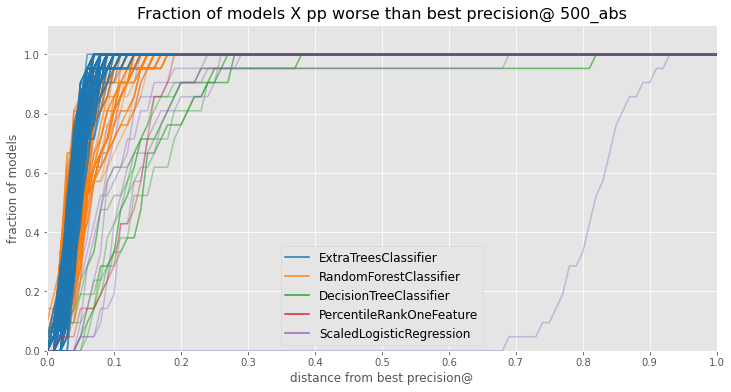

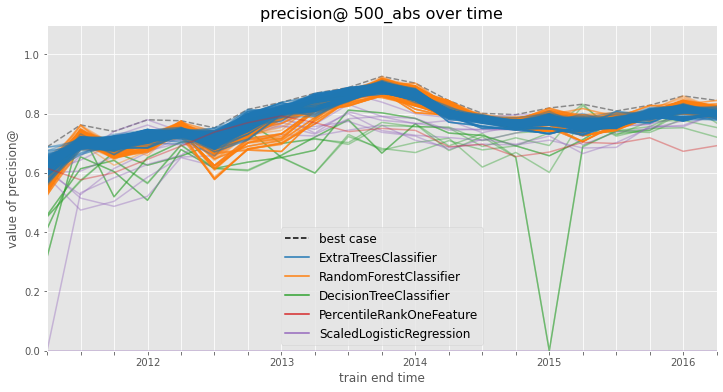

In [46]:
aud.plot_model_groups()

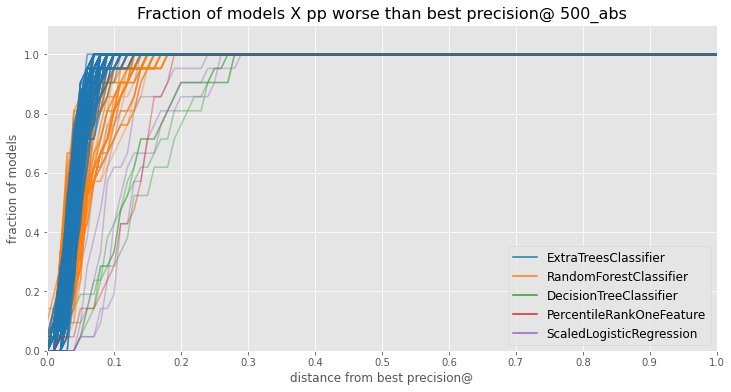

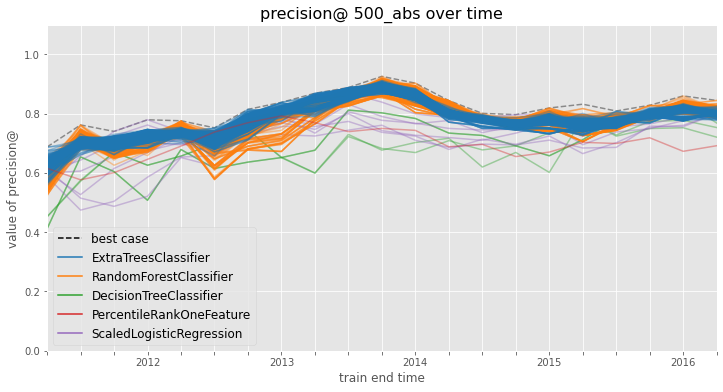

541

In [48]:
aud.update_metric_filters([{
    'metric': metric, 
    'parameter': parameter, 
    'max_from_best': 0.1, 
    'threshold_value': 0.4
}])
len(aud.thresholded_model_group_ids)

In [49]:
set(new_model_groups) - set(aud.thresholded_model_group_ids)

{61, 95, 106, 112, 115, 118}